In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import torchvision.transforms as transforms
from torchvision.datasets import ImageFolder
import timm

import matplotlib.pyplot as plt
from tqdm.notebook import tqdm

Dataset

In [2]:
class TomatoLeavesDataset(Dataset):
    def __init__(self, data_dir, transform=None):
        self.data = ImageFolder(data_dir, transform=transform)
    
    def __len__(self):
        return len(self.data)
    
    def __getitem__(self, idx):
        return self.data[idx]
    
    @property
    def classes(self):
        return self.data.classes

In [3]:
dataset = TomatoLeavesDataset(
    data_dir='data/train'
)

In [4]:
len(dataset)

11203

6


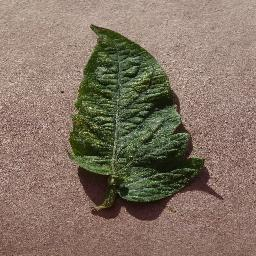

In [5]:
image, label = dataset[7000]
print(label)
image

In [6]:
# Get a dictionary associating target values with folder names
data_dir = 'data/train'
target_to_class = {v: k for k, v in ImageFolder(data_dir).class_to_idx.items()}
print(target_to_class)

{0: 'Tomato_Bacterial_spot', 1: 'Tomato_Early_blight', 2: 'Tomato_Healthy', 3: 'Tomato_Late_blight', 4: 'Tomato_Leaf_Mold', 5: 'Tomato_Septoria_leaf_spot', 6: 'Tomato_Spider_mites_Two_spotted_spider_mite', 7: 'Tomato__Target_Spot', 8: 'Tomato__Tomato_YellowLeaf__Curl_Virus', 9: 'Tomato__Tomato_mosaic_virus'}


In [7]:
transform = transforms.Compose([
    transforms.Resize((256, 256)),
    transforms.ToTensor(),
])

data_dir = 'data/train'
dataset = TomatoLeavesDataset(data_dir, transform)

In [8]:
image, label = dataset[100]
image.shape

torch.Size([3, 256, 256])

Dataloaders

In [9]:
dataloader = DataLoader(dataset, batch_size=32, shuffle=True)

In [10]:
for images, labels in dataloader:
    break

In [11]:
images.shape, labels.shape

(torch.Size([32, 3, 256, 256]), torch.Size([32]))

In [12]:
labels

tensor([0, 2, 5, 3, 2, 3, 3, 2, 7, 5, 1, 0, 5, 8, 0, 2, 3, 2, 4, 3, 3, 8, 5, 0,
        4, 5, 6, 8, 0, 4, 8, 7])

Pytorch Model

In [13]:
class TomatoLeavesClassifer(nn.Module):
    def __init__(self, num_classes=10):
        super(TomatoLeavesClassifer, self).__init__()
        # Where we define all the parts of the model
        self.base_model = timm.create_model('efficientnet_b0', pretrained=True)
        self.features = nn.Sequential(*list(self.base_model.children())[:-1])

        enet_out_size = 1280
        # Make a classifier
        self.classifier = nn.Sequential(
            nn.Flatten(),
            nn.Linear(enet_out_size, num_classes)
        )
    
    def forward(self, x):
        # Connect these parts and return the output
        x = self.features(x)
        output = self.classifier(x)
        return output


In [14]:
model = TomatoLeavesClassifer(num_classes=10)
print(str(model)[:500])

TomatoLeavesClassifer(
  (base_model): EfficientNet(
    (conv_stem): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
    (bn1): BatchNormAct2d(
      32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True
      (drop): Identity()
      (act): SiLU(inplace=True)
    )
    (blocks): Sequential(
      (0): Sequential(
        (0): DepthwiseSeparableConv(
          (conv_dw): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=F


In [15]:
example_out = model(images)
example_out.shape # [batch_size, num_classes]

torch.Size([32, 10])

In [16]:
# Loss function
criterion = nn.CrossEntropyLoss()
# Optimizer
optimizer = optim.Adam(model.parameters(), lr=0.001)

In [17]:
criterion(example_out, labels)
print(example_out.shape, labels.shape)

torch.Size([32, 10]) torch.Size([32])


In [25]:
transform = transforms.Compose([
    transforms.Resize((256, 256)),
    transforms.ToTensor(),
])

train_folder = 'data/train/'
valid_folder = 'data/valid/'
test_folder = 'data/test/'

train_dataset = TomatoLeavesDataset(train_folder, transform=transform)
val_dataset = TomatoLeavesDataset(valid_folder, transform=transform)
test_dataset = TomatoLeavesDataset(test_folder, transform=transform)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

Training loop

In [32]:
torch.cuda.is_available()

True

In [20]:
# Simple training loop
num_epochs = 5
train_losses, val_losses = [], []

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

model = TomatoLeavesClassifer(num_classes=10)
model.to(device)

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

for epoch in range(num_epochs):
    # Training phase
    model.train()
    running_loss = 0.0
    for images, labels in tqdm(train_loader, desc='Training loop'):
        # Move inputs and labels to the device
        images, labels = images.to(device), labels.to(device)
        
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item() * labels.size(0)
    train_loss = running_loss / len(train_loader.dataset)
    train_losses.append(train_loss)
    
    # Validation phase
    model.eval()
    running_loss = 0.0
    with torch.no_grad():
        for images, labels in tqdm(val_loader, desc='Validation loop'):
            # Move inputs and labels to the device
            images, labels = images.to(device), labels.to(device)
         
            outputs = model(images)
            loss = criterion(outputs, labels)
            running_loss += loss.item() * labels.size(0)
    val_loss = running_loss / len(val_loader.dataset)
    val_losses.append(val_loss)
    print(f"Epoch {epoch+1}/{num_epochs} - Train loss: {train_loss}, Validation loss: {val_loss}")


Training loop:   0%|          | 0/351 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/75 [00:00<?, ?it/s]

Epoch 1/5 - Train loss: 0.23653293774562745, Validation loss: 0.22383913013448456


Training loop:   0%|          | 0/351 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/75 [00:00<?, ?it/s]

Epoch 2/5 - Train loss: 0.0942050356853171, Validation loss: 0.13526994188792707


Training loop:   0%|          | 0/351 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/75 [00:00<?, ?it/s]

Epoch 3/5 - Train loss: 0.062241120092516915, Validation loss: 0.10471113279385513


Training loop:   0%|          | 0/351 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/75 [00:00<?, ?it/s]

Epoch 4/5 - Train loss: 0.05074595178315443, Validation loss: 0.09274587653445517


Training loop:   0%|          | 0/351 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/75 [00:00<?, ?it/s]

Epoch 5/5 - Train loss: 0.07184267586953709, Validation loss: 0.0710005689231006


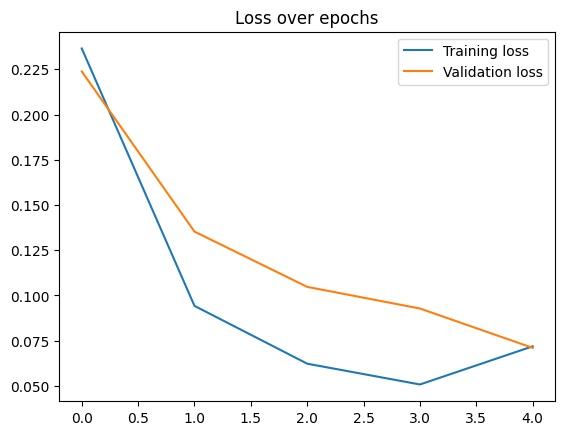

In [21]:
plt.plot(train_losses, label='Training loss')
plt.plot(val_losses, label='Validation loss')
plt.legend()
plt.title("Loss over epochs")
plt.show()

In [24]:
# torch.save(model.state_dict(), 'model.pth')

Test on some examples

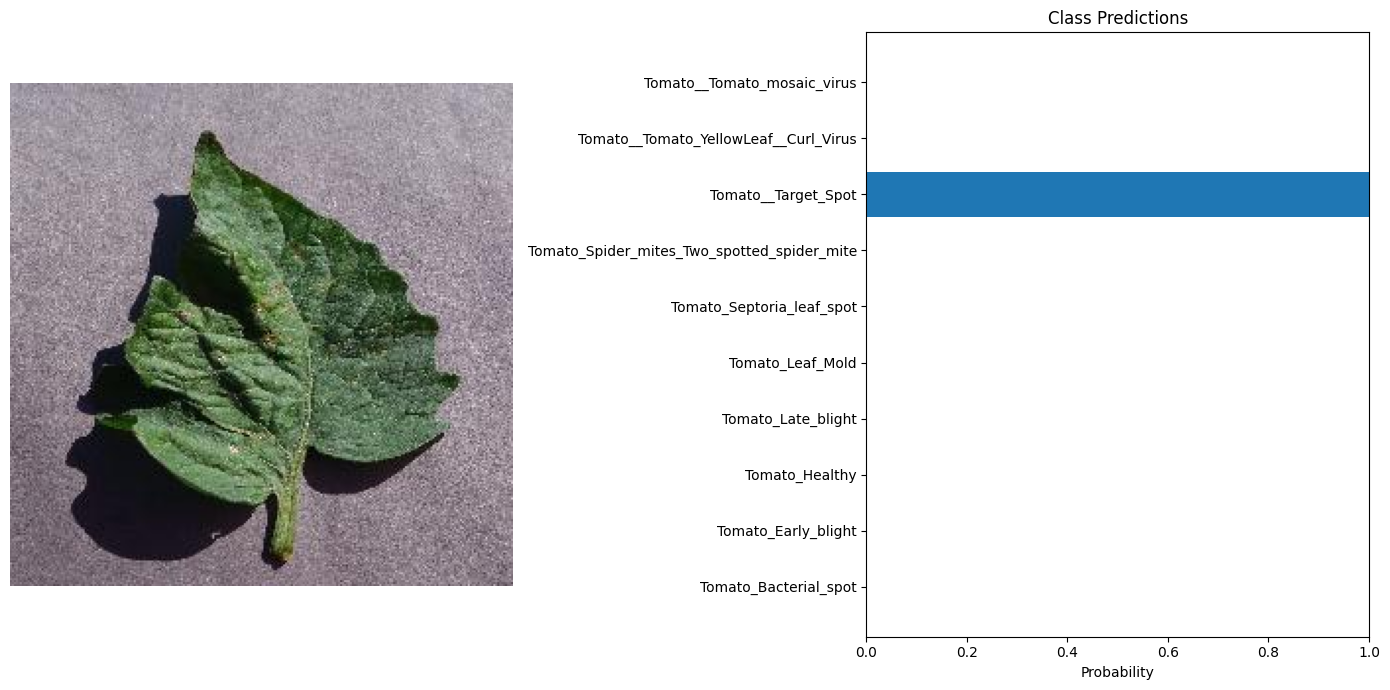

In [22]:
import torch
import torchvision.transforms as transforms
from PIL import Image
import matplotlib.pyplot as plt
import numpy as np

# Load and preprocess the image
def preprocess_image(image_path, transform):
    image = Image.open(image_path).convert("RGB")
    return image, transform(image).unsqueeze(0)

# Predict using the model
def predict(model, image_tensor, device):
    model.eval()
    with torch.no_grad():
        image_tensor = image_tensor.to(device)
        outputs = model(image_tensor)
        probabilities = torch.nn.functional.softmax(outputs, dim=1)
    return probabilities.cpu().numpy().flatten()

# Visualization
def visualize_predictions(original_image, probabilities, class_names):
    fig, axarr = plt.subplots(1, 2, figsize=(14, 7))
    
    # Display image
    axarr[0].imshow(original_image)
    axarr[0].axis("off")
    
    # Display predictions
    axarr[1].barh(class_names, probabilities)
    axarr[1].set_xlabel("Probability")
    axarr[1].set_title("Class Predictions")
    axarr[1].set_xlim(0, 1)

    plt.tight_layout()
    plt.show()

test_image = "data/test/Tomato__Target_Spot/0a458dfc-b513-44f2-a3ce-dab4c3adb939___Com.G_TgS_FL 8166.JPG"
transform = transforms.Compose([
    transforms.Resize((256, 256)),
    transforms.ToTensor()
])

original_image, image_tensor = preprocess_image(test_image, transform)
probabilities = predict(model, image_tensor, device)

class_names = dataset.classes 
visualize_predictions(original_image, probabilities, class_names)

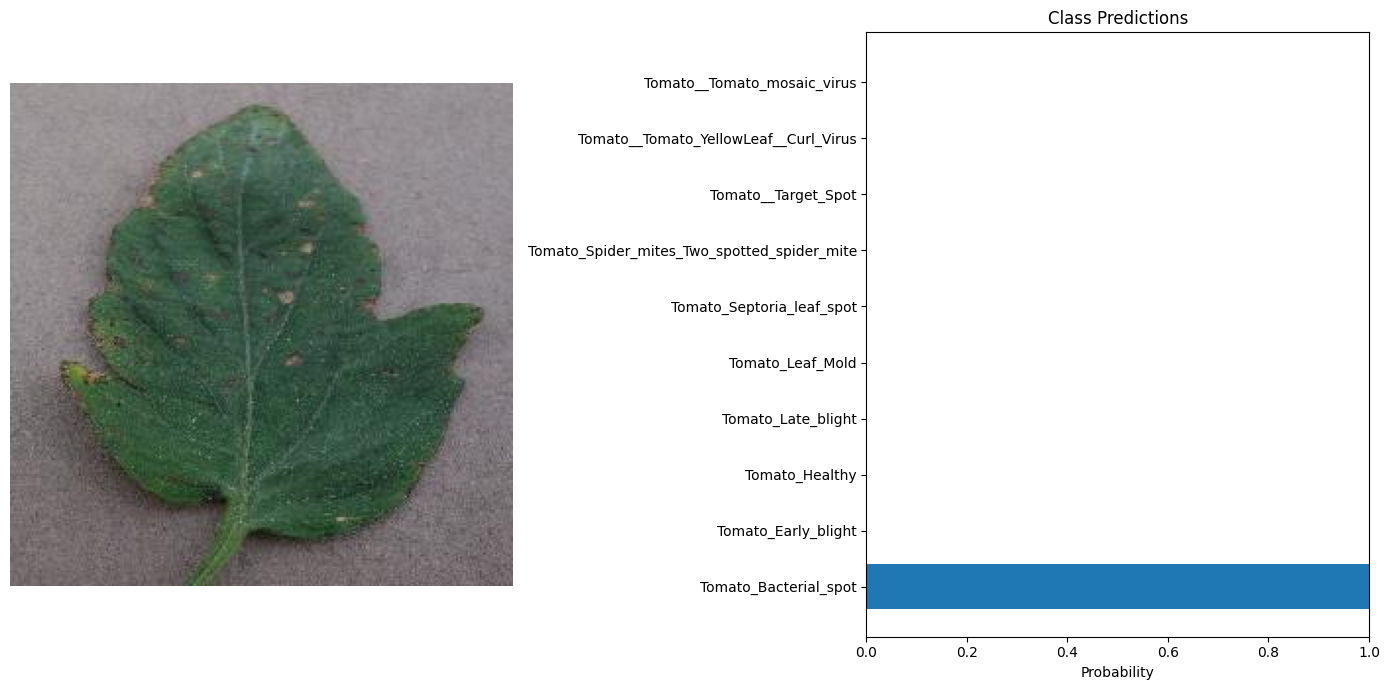

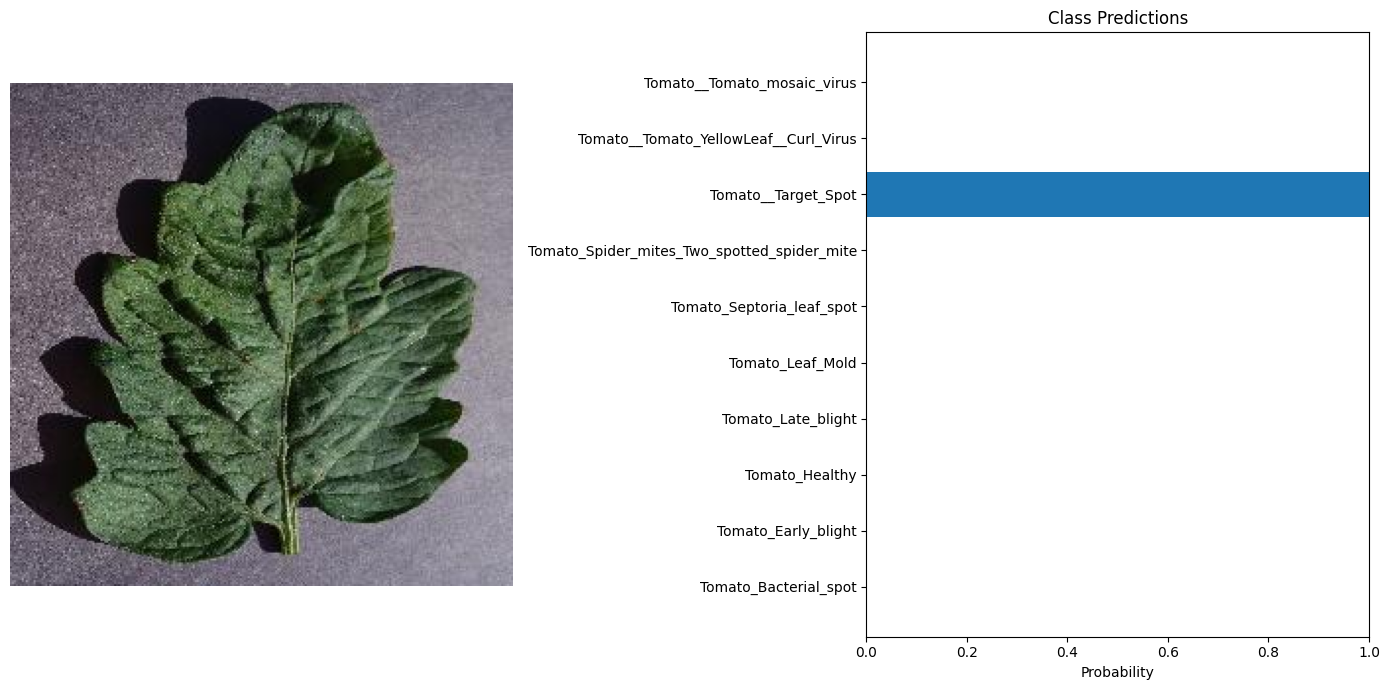

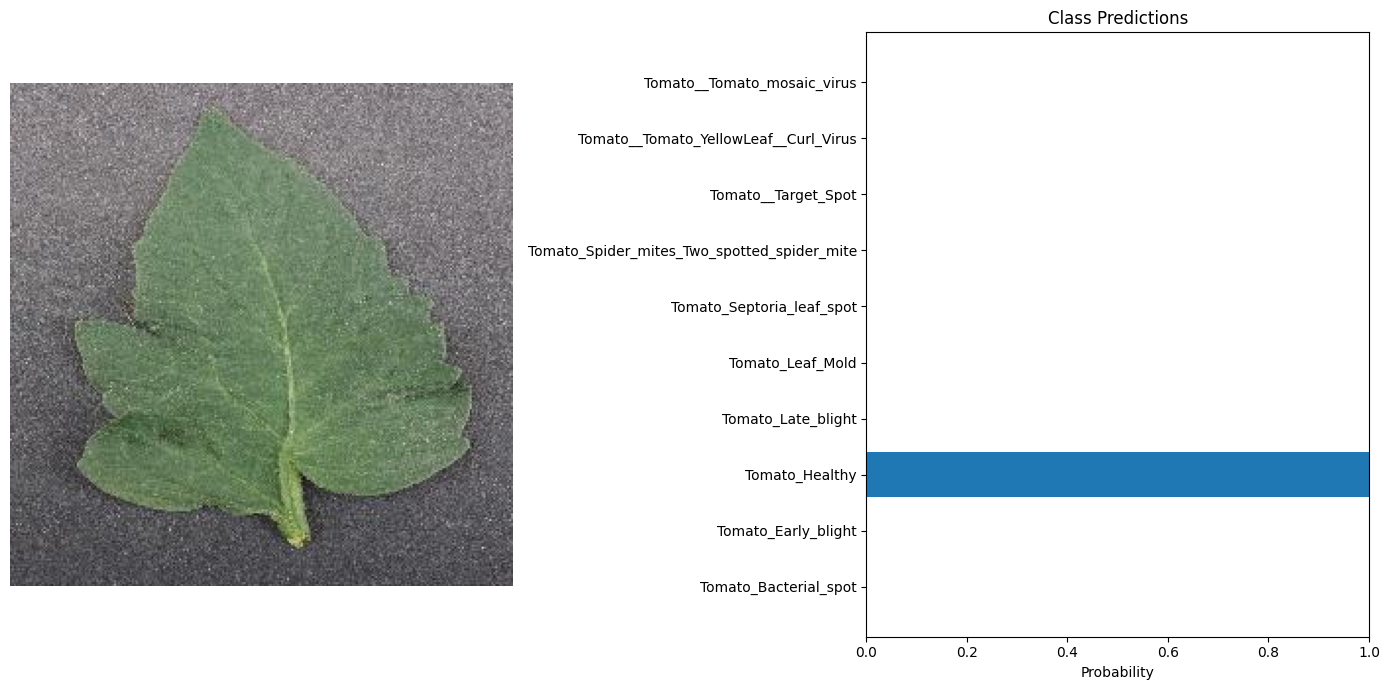

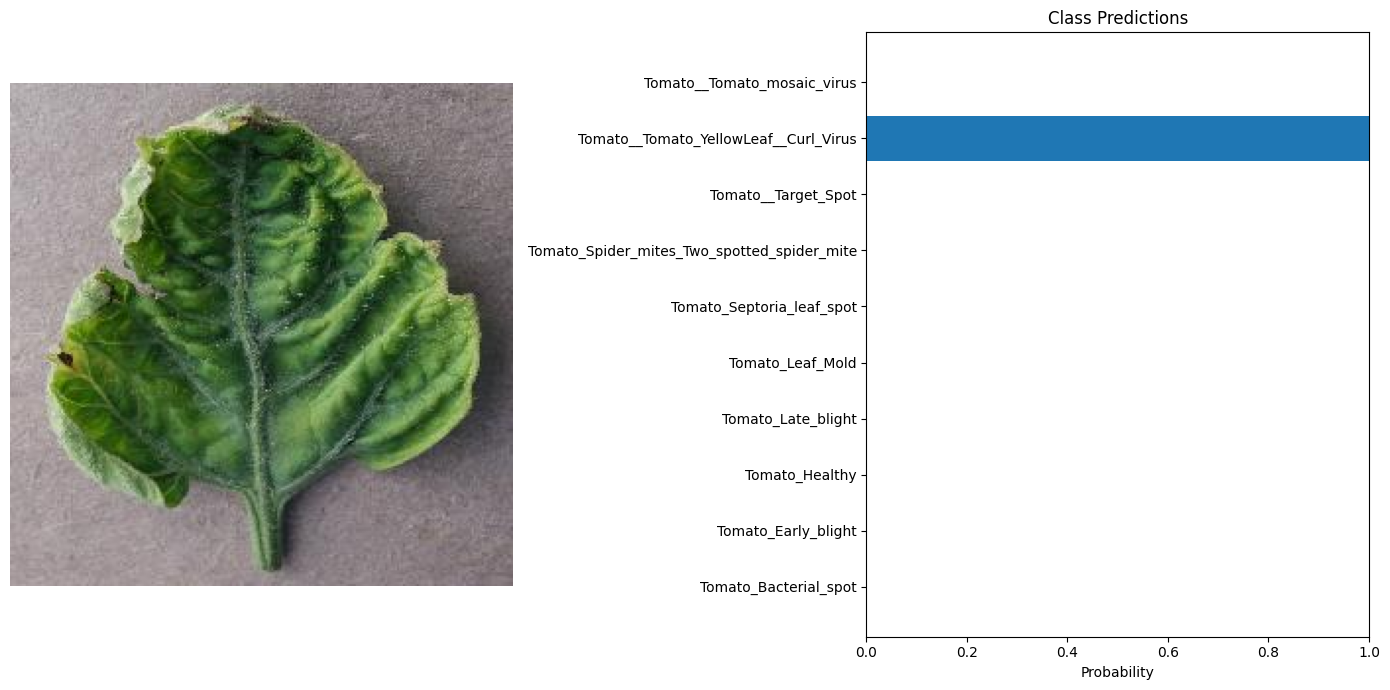

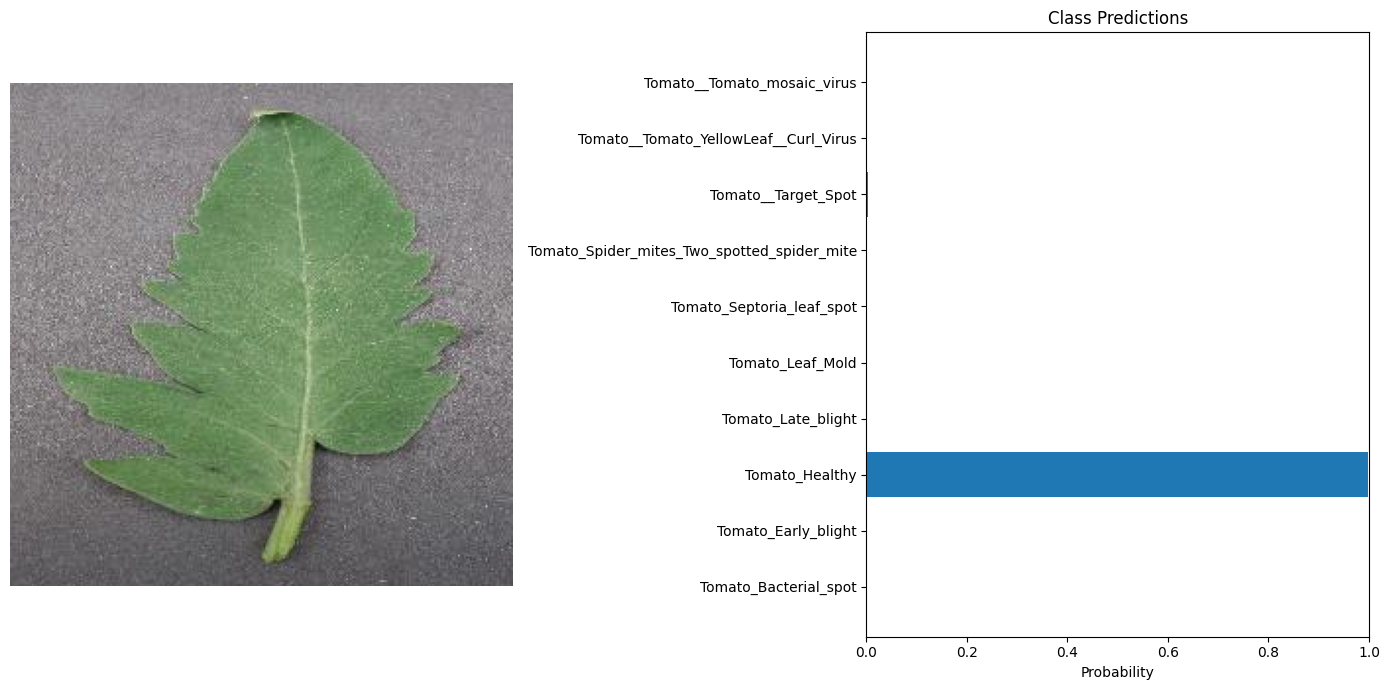

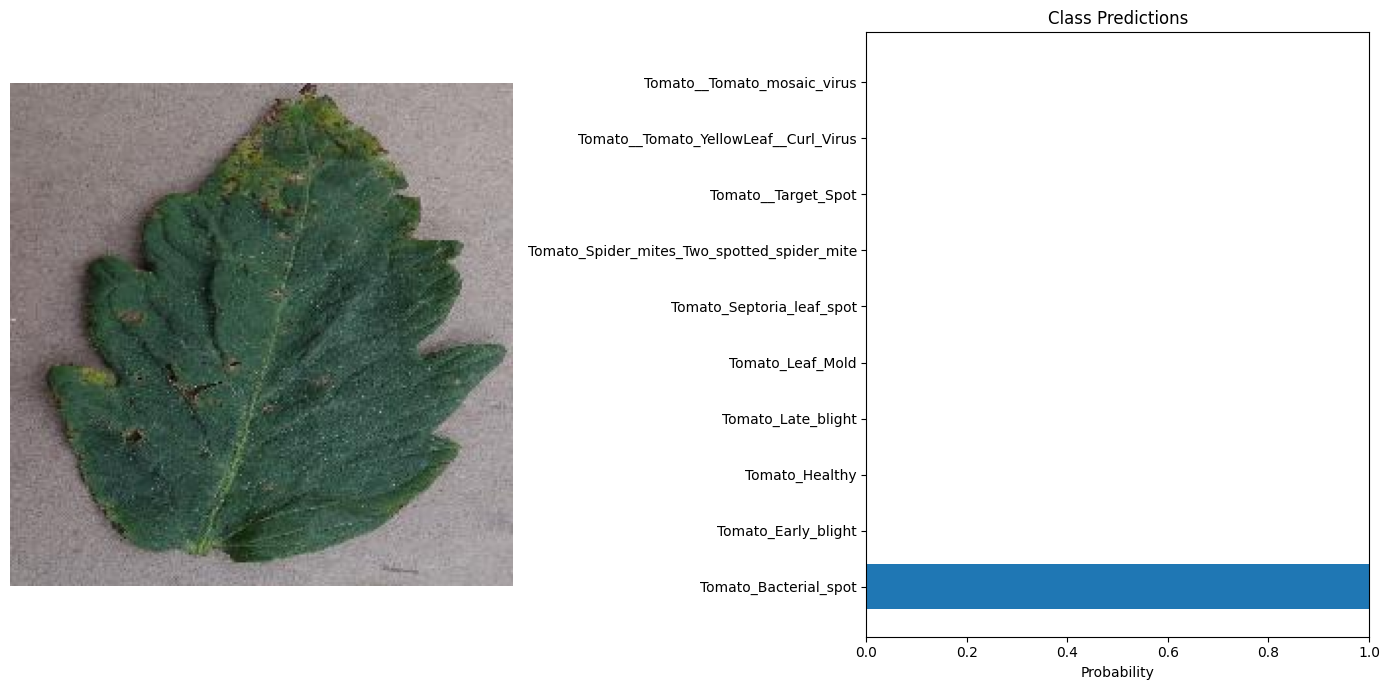

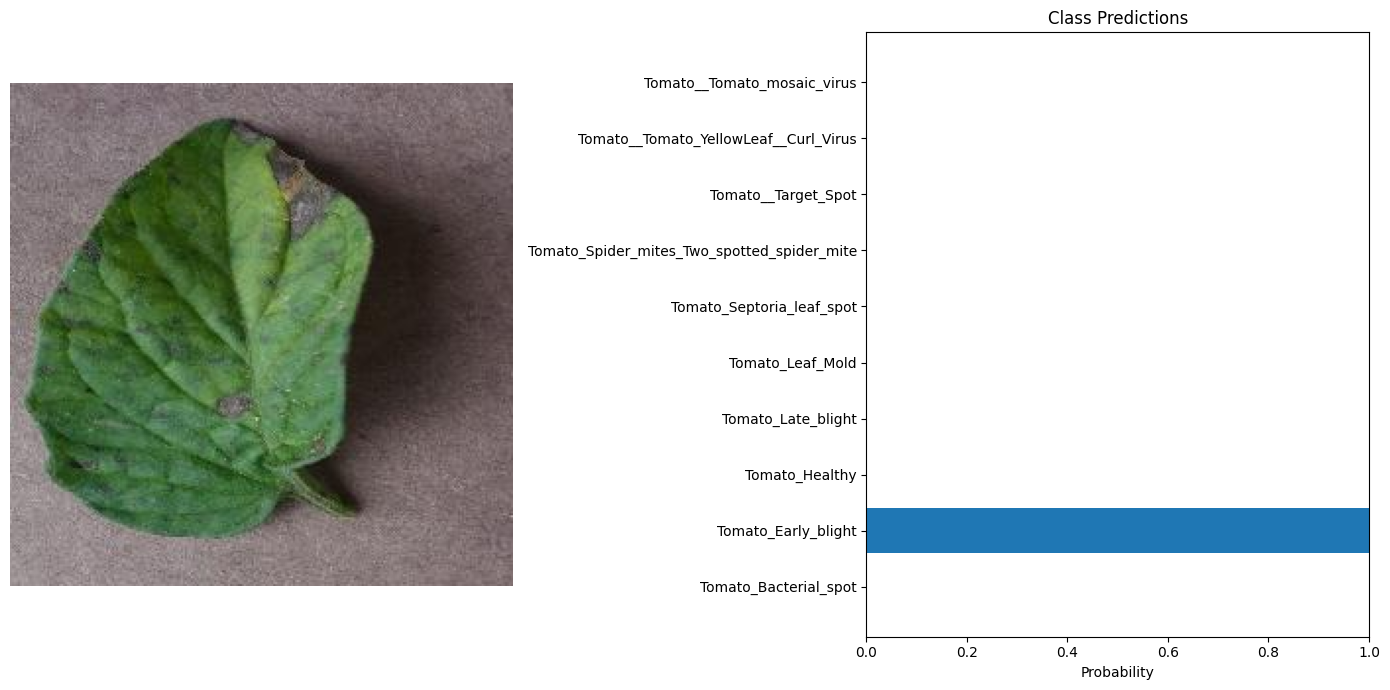

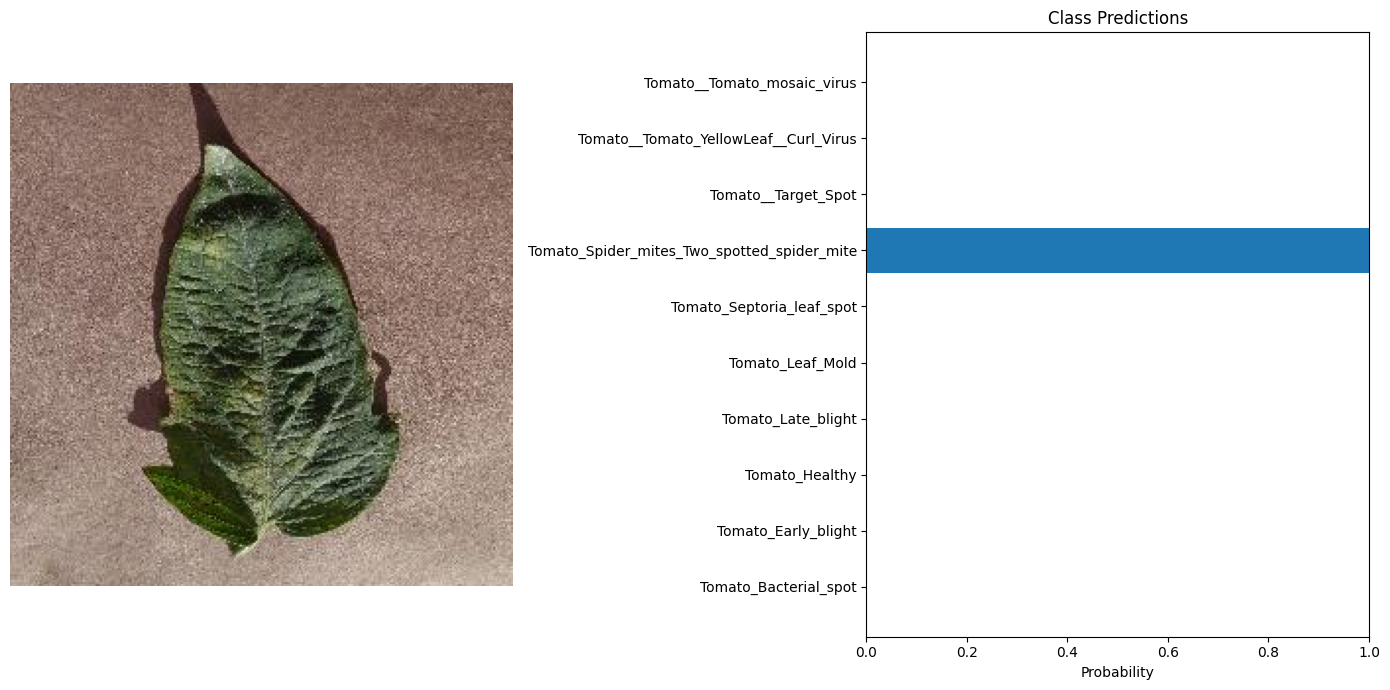

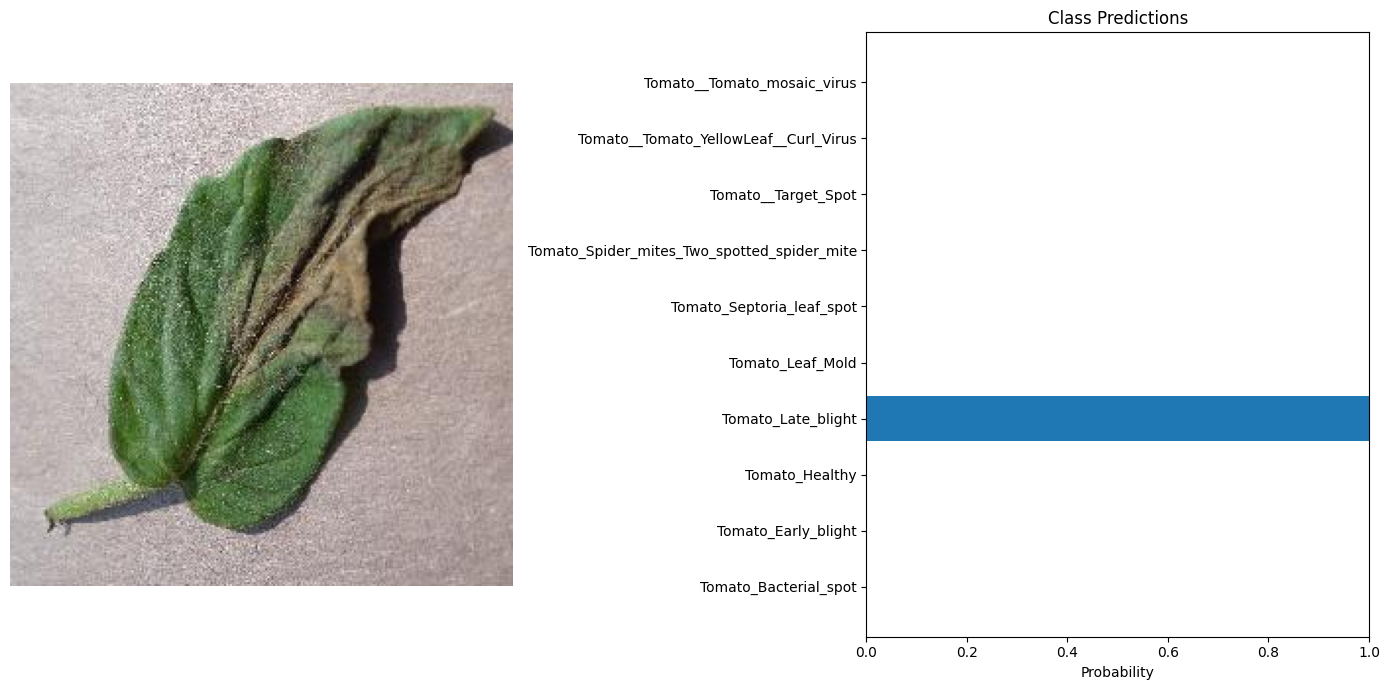

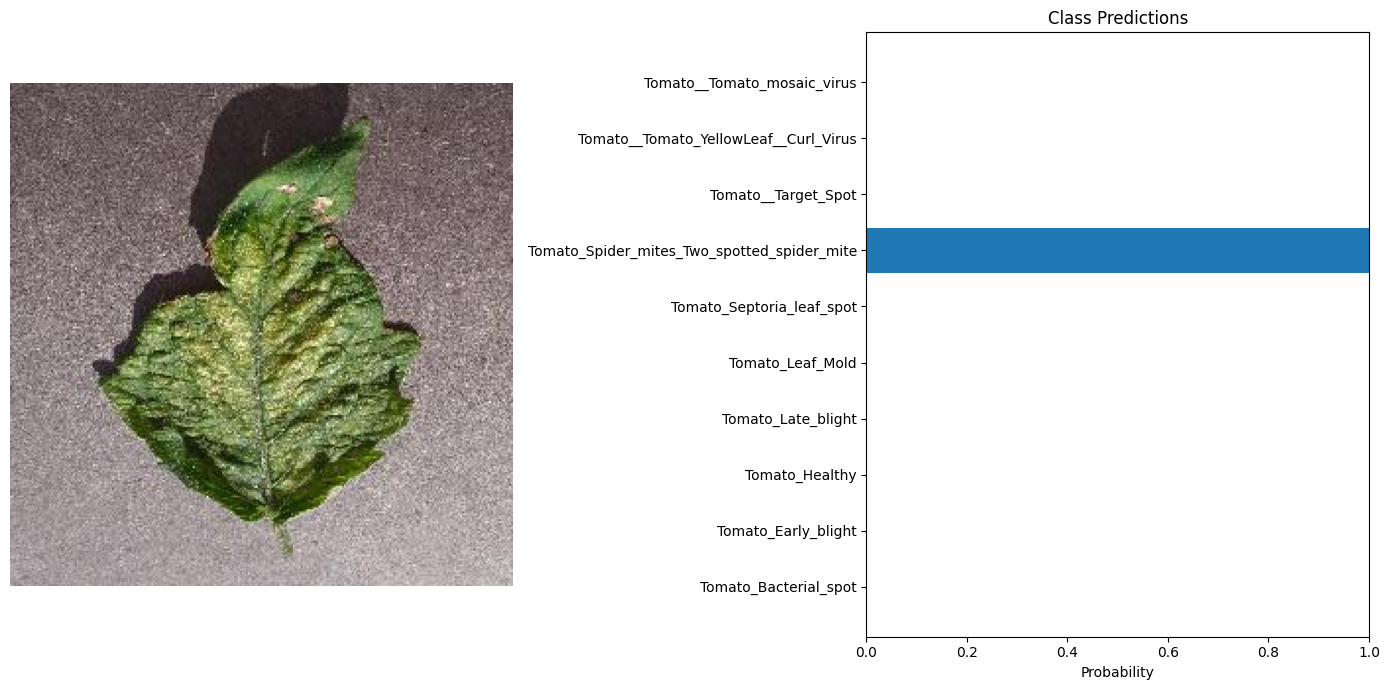

In [23]:
from glob import glob
test_images = glob('data/test/*/*')
test_examples = np.random.choice(test_images, 10)

for example in test_examples:
    original_image, image_tensor = preprocess_image(example, transform)
    probabilities = predict(model, image_tensor, device)

    # Assuming dataset.classes gives the class names
    class_names = dataset.classes 
    visualize_predictions(original_image, probabilities, class_names)

Test accuracy

In [ ]:
model = TomatoLeavesClassifer() 
model.load_state_dict(torch.load('model.pth'))
model.eval() 

In [31]:
correct = 0
total = 0
model.to(device)

with torch.no_grad():
    for images, labels in tqdm(test_loader, desc="Test loop"):
        images, labels = images.to(device), labels.to(device)

        outputs = model(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

accuracy = 100 * correct / total
print(f'Accuracy of the model on the test images: {accuracy:.2f}%')

Test loop:   0%|          | 0/76 [00:00<?, ?it/s]

Accuracy of the model on the test images: 98.18%
